# Downscaled precipitation with conservative regridding

This notebook serves to visualize some of the downscaled data produced by conservative regridding + quantile delta mapping. The [`preprocess.ipynb`](./preprocess.ipynb) notebook is used to create the downscaled data. 

In [ ]:
# config cell
import warnings
from pathlib import Path
import xesmf as xe
import xarray as xr
import cf_xarray as cfxr
from xclim import units, sdba, indices
from dask.distributed import Client
import dask
import matplotlib.pyplot as plt

dask.config.set({"large-graph-warning-threshold": "100MB"})

# pn.extension(comms="vscode")
# for reloading the baeda module which is actively developing
import baeda
from importlib import reload

# target grid file
target_grid_file = Path("/beegfs/CMIP6/kmredilla/downscaling/era5_target_slice.nc")

# cmip6 dir
cmip6_dir = Path("/beegfs/CMIP6/arctic-cmip6/CMIP6")

# era5_dir = Path("/beegfs/CMIP6/kmredilla/era5_3338_zarr/zarr")
era5_dir = Path("/center1/CMIP6/kmredilla/era5_zarr")

# tmp dir for writing inputs/outputs
tmp_dir = Path("/beegfs/CMIP6/kmredilla/downscaling/eda")
tmp_regrid_fn = "{var_id}_{model}_{scenario}_regrid_{interp_method}.zarr"
tmp_adj_fn = "{var_id}_{model}_{scenario}_adj_{interp_method}.zarr"


var_id = "pr"
hist_regrid_path = tmp_dir.joinpath(
    tmp_regrid_fn.format(
        var_id="pr",
        model="GFDL-ESM4",
        scenario="historical",
        interp_method="conservative",
    )
)
hist_adj_path = tmp_dir.joinpath(
    tmp_adj_fn.format(
        var_id="pr",
        model="GFDL-ESM4",
        scenario="historical",
        interp_method="conservative",
    )
)
hist_idx_path = tmp_dir.joinpath(
    tmp_adj_fn.format(
        var_id=var_id + "idx",
        model="GFDL-ESM4",
        scenario="historical",
        interp_method="conservative",
    )
)

# connect to regridded, adjusted (downscaled), and derived indices datasets
hist_ds = xr.open_zarr(hist_regrid_path)
hist_adj_ds = xr.open_zarr(hist_adj_path)  # .transpose("time", "y", "x")
hist_idx_ds = xr.open_zarr(hist_idx_path)  # .transpose("time", "y", "x")

# connect to ERA5 data
era5_stores = {
    # "t2max": era5_dir.joinpath("t2max_era5.zarr"),
    "pr": era5_dir.joinpath("pr_era5.zarr"),
}
era5_ds = baeda.open_era5_dataset(era5_stores)

era5_idx_fp = tmp_dir.joinpath(f"{var_id + 'idx'}_era5.zarr")
era5_idx_ds = xr.open_zarr(era5_idx_fp)

# get the precip datarrays
era5 = era5_ds["pr"]
hist = hist_ds["pr"]
hist_adj = hist_adj_ds["pr"]

In [2]:
client = Client()

In [3]:
hist_idx_ds = hist_idx_ds.load()
era5_idx_ds = era5_idx_ds.load()

Without using some type of regridding where smoothing is used, underlying GCM pixels will be evident at the daily scale. Example:

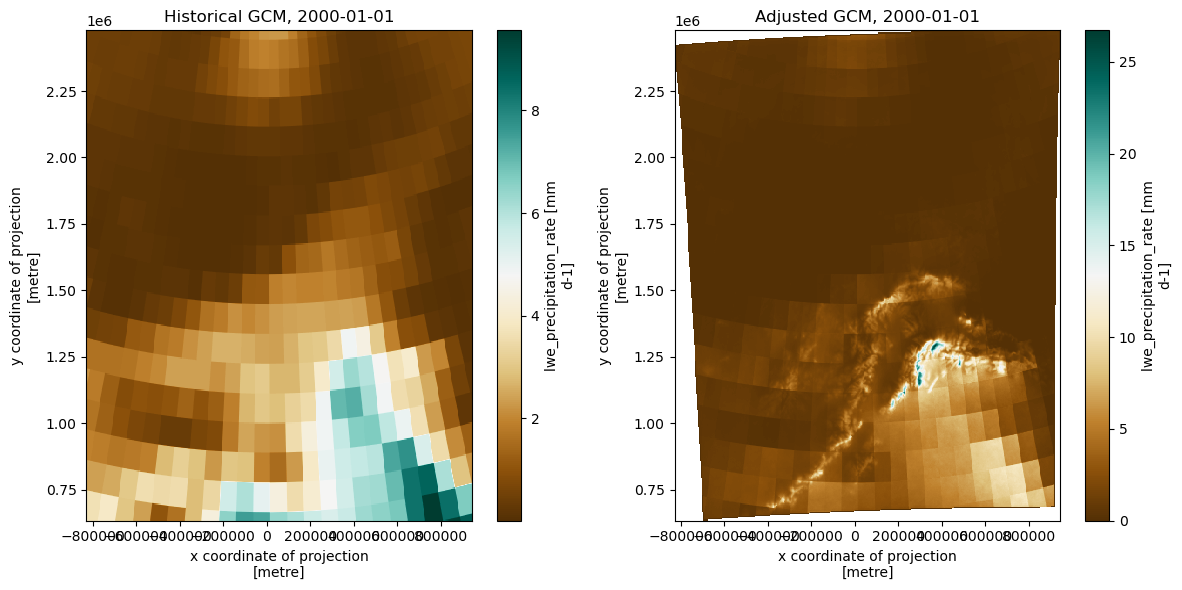

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot original historical data
time_sl = "2000-01-01"
hist.sel(time=time_sl).plot(ax=axs[0], cmap="BrBG")
axs[0].set_title(f"Historical GCM, {time_sl}")

# Plot adjusted historical data
hist_adj.sel(time=time_sl).plot(ax=axs[1], cmap="BrBG")
axs[1].set_title(f"Adjusted GCM, {time_sl}")

plt.tight_layout()
plt.show()

Aggregation operations seem to smooth this out, e.g. 10-year mean:

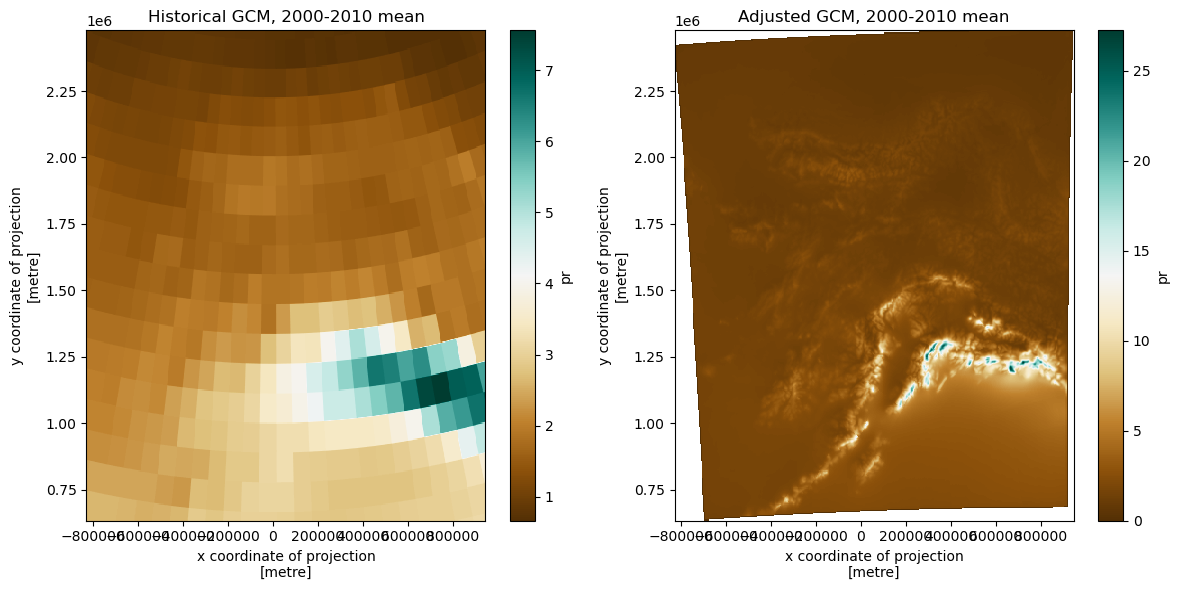

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot original historical data
time_sl = slice("2000", "2010")
hist.sel(time=time_sl).mean("time").plot(ax=axs[0], cmap="BrBG")
axs[0].set_title("Historical GCM, 2000-2010 mean")

# Plot adjusted historical data
hist_adj.sel(time=time_sl).mean("time").plot(ax=axs[1], cmap="BrBG")
axs[1].set_title("Adjusted GCM, 2000-2010 mean")

plt.tight_layout()
plt.show()

### Indicator climatology deltas ($Downscaled - ERA5$)

Here is the main event of this notebook, as the impetus for considering other interpolation methods was the fairly large differences in indicator climatology deltas (downscaled GCM minus ERA5) for rx1day and rx5day indices.

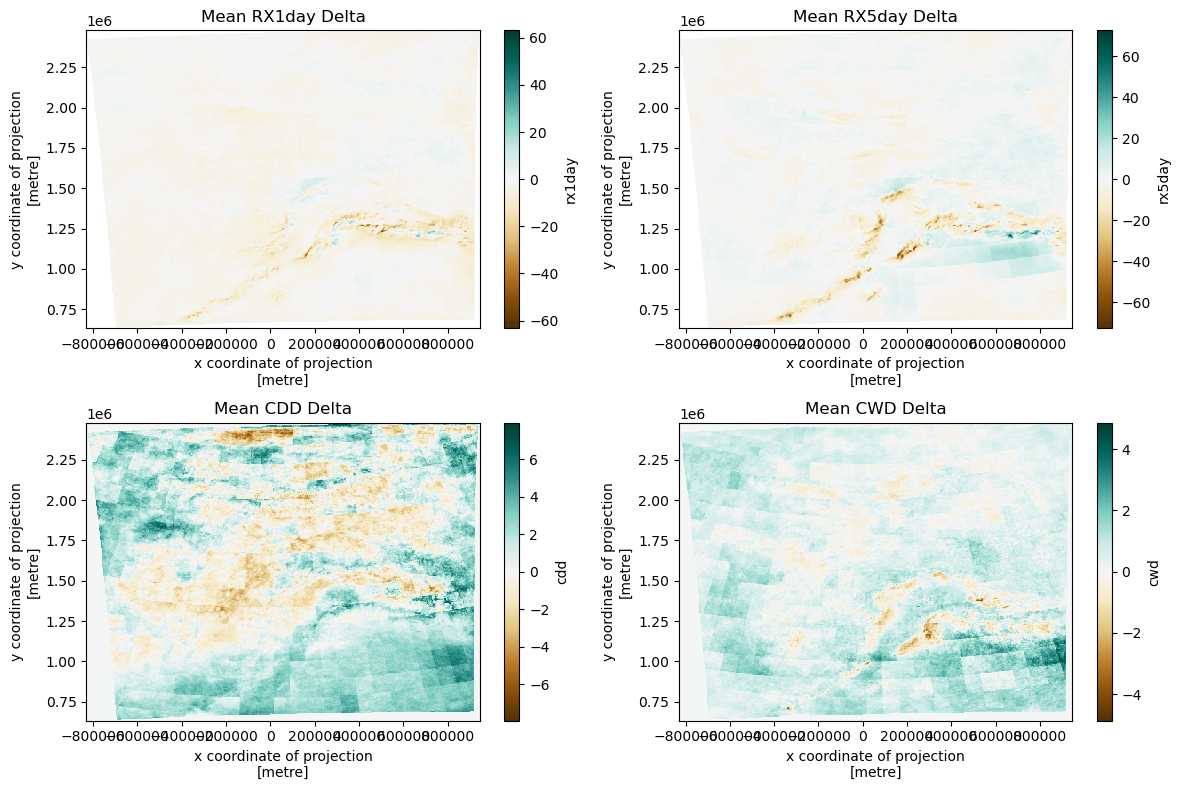

In [7]:
mean_idx_deltas = hist_idx_ds.mean(dim="time") - era5_idx_ds.mean(dim="time")

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
mean_idx_deltas["rx1day"].plot(cmap="BrBG", ax=axs[0, 0])
axs[0, 0].set_title("Mean RX1day Delta")
mean_idx_deltas["rx5day"].plot(cmap="BrBG", ax=axs[0, 1])
axs[0, 1].set_title("Mean RX5day Delta")
mean_idx_deltas["cdd"].plot(cmap="BrBG", ax=axs[1, 0])
axs[1, 0].set_title("Mean CDD Delta")
mean_idx_deltas["cwd"].plot(cmap="BrBG", ax=axs[1, 1])
axs[1, 1].set_title("Mean CWD Delta")

plt.tight_layout()
plt.show()